# Analysing cavitation data

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import plotly
plotly.offline.init_notebook_mode()

## Useful functions & Class

In [3]:
def create_dict(keys, values):
    '''
    create dictionary from two lists
    '''
    dictionary = dict(zip(keys, values))
    return dictionary

In [4]:
def grouping_pop(df, level, start_rename):   
    '''
    creating summary tables with mean, std and n values per group defined by level
    '''
    df_mean = df.groupby(level).mean().reset_index().dropna(axis = 1)    
    temp_dict = [create_dict(df_mean.columns[start_rename::], df_mean.columns[start_rename::]+ i) for i in ['_mean', '_std']]
    df_mean = df_mean.rename(columns = temp_dict[0])    
    df_std = df.groupby(level).std().reset_index().dropna(axis = 1, thresh=5)    
    df_std= df_std.rename(columns = temp_dict[1])    
    df_n = df.groupby(level).size().reset_index(name='counts')    
    return df_mean, df_std, df_n

In [5]:
def plot_heatmap(cor, mode, ann=False):
    '''
    plot heatmap from a correlation matrix, 2 modes avalaible
    abs: compute the absolute values of the correlation matrix (values bounded between [0-1])
    cor: raw correlation values (values bounded between [-1-1])
    '''
    assert mode in ['cor','abs'], 'mode should be one of ["cor","abs"]'       
    if mode == 'cor':
        vm = -1
    else :
        vm = 0
        cor = np.abs(cor)        
    fig, ax = plt.subplots(figsize=(15, 15))# mask
    mask = np.triu(np.ones_like(cor, dtype=np.bool))# adjust mask and df
    mask = mask[1:, :-1]
    corr = cor.iloc[1:,:-1].copy()# plot heatmap    
    sns.heatmap(corr, mask=mask, annot=ann, fmt=".2f", cmap='Blues',
               vmin=vm, vmax=1, cbar_kws={"shrink": .8})# yticks
    plt.yticks(rotation=0)
    plt.show()

In [6]:
def mean_confidence_interval(sm, n, confidence=0.95, verbose = False): 
    '''
    compute the delta to mean value for computing confidence interval
    
    sm : standard deviation of the mean
    n : number of individuals
    
    return the delta to mean value for computing confidence interval (to be added to the mean value)
    '''
    
    def compute_t(confidence, ni):
        t=stats.t.ppf((1 + confidence) / 2., ni-1)
        return t    
    
    tval = [compute_t(confidence, ni) for ni in n]
    n = np.array(n)
    sm = np.array(sm)
    tval = np.array(tval)
    
    h = np.array(sm)/np.sqrt(n) * np.array(tval)
    if verbose:
        print('t values : {}'.format(np.around(tval, decimals=2)))
        print('\nse values : {}'.format(np.around(sm, decimals=2)))
        print('\nci values : {}'.format(np.around(h, decimals=2)))
    return h 


In [7]:
class MyPCA():
    '''
    file:///home/xavier/Downloads/fr_Tanagra_ACP_Python.pdf
    '''
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import numpy as np
    import pandas as pd
    
    def __init__(self, df):
        self.df = df
        self.n = df.shape[0]
        self.p = df.shape[1]
        
    def standardize(self):
        sc = StandardScaler()
        self.Z = sc.fit_transform(self.df)
        
    def dopca(self):
        try:
            self.Z
        except:
            print("Z is not defined please standardize before")
            
        self.acp = PCA(svd_solver='full')
        self.coord = self.acp.fit_transform(self.Z)
        self.eigval = self.acp.explained_variance_
    
    def assess_pca(self):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
        ax1.bar(np.arange(1,self.p +1),self.acp.explained_variance_)
        ax1.set_title("Scree plot")
        ax1.set_ylabel("Eigen values")
        ax1.set_xlabel("Factor number")
       
        ax2.bar(np.arange(1,self.p+1),np.cumsum(self.acp.explained_variance_ratio_))
        ax2.set_title("Explained variance vs. # of factors")
        ax2.set_ylabel("Cumsum explained variance ratio")
        ax2.set_xlabel("Factor number")
        plt.show()
    
    def plot_indiv(self, label):
        fig, axes = plt.subplots(figsize=(12,12))
        axes.set_xlim(-6,6) #même limites en abscisse
        axes.set_ylim(-6,6) #et en ordonnée

        #placement des étiquettes des observations
        
        assert self.n == label.shape[0], 'rows number should have the same length than label'
        
        for i in range(self.n):
            plt.annotate(label[i],(self.coord[i,0],self.coord[i,1]))
        #ajouter les axes
        plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
        plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)#affichage
        plt.show()        

    
    def _compute_corvar(self):
        print('computing factor variable correlation')
        sqrt_eigval = np.sqrt(self.eigval)
        #corrélation des variables avec les axes
        self.corvar = np.zeros((self.p,self.p))
        for k in range(self.p):
            self.corvar[:,k] = self.acp.components_[k,:] * sqrt_eigval[k]
            #afficher la matrice des corrélations variables x facteurs  
        
    def plot_features(self, label):
        self._compute_corvar()
        fig, axes = plt.subplots(figsize=(8,8))
        axes.set_xlim(-1,1)
        axes.set_ylim(-1,1)
        #affichage des étiquettes (noms des variables)
        
        assert self.p == label.shape[0], 'cols number should have the same length than label'
        
        for j in range(self.p):
            plt.annotate(label[j],(self.corvar[j,0],self.corvar[j,1]))

        #ajouter les axes
        plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
        plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

        #ajouter un cercle
        cercle = plt.Circle((0,0),1,color='blue',fill=False)
        axes.add_artist(cercle)

        #affichage
        plt.show()
        
    def compute_cos2(self):
        try:
            self.corvar
        except:
            print("corvar is not defined, use plot_features before")
            
        self.cos2var = self.corvar**2
        
        print('Axis 1\n---------------------------------------------\n')
        print(pd.DataFrame({'id':self.df.columns,'COS2_1':self.cos2var[:,0],'COS2_2':self.cos2var[:,1]}).sort_values('COS2_1', ascending = False))
        print('Axis 2\n---------------------------------------------\n')
        print(pd.DataFrame({'id':self.df.columns,'COS2_1':self.cos2var[:,0],'COS2_2':self.cos2var[:,1]}).sort_values('COS2_2', ascending = False))

        
        
        

## Plot of the pop

![title](img/map1.png)

## Importing data

In [8]:
# import df
df = pd.read_table("/home/xavier/Documents/research/FORMANRISK/data/data_formanrisk/individual_join.csv", sep = ";")
# remove few columns
df = df.drop(columns = ["X","Y",'X_TYPE_', 'X_FREQ_', 'individual', 'branch_diam', 'branch_diamn','num', 
                        'P50n','P12n','P88n','slopen','Kmaxn'])
print('dimensions of df are \nnrows : {0}\nncols : {1}'.format(df.shape[0], df.shape[1]))

dimensions of df are 
nrows : 440
ncols : 44


## Some data cleaning

### Renaming

In [9]:
# remove the _15 from bioclim var
df.columns = [re.sub("_15", "", c) for c in df.columns]

In [10]:
# extracting index of bioclim var
bio_index  = [i for i, item in enumerate(df.columns) if re.search('bio\d{1,2}', item)]

In [11]:
# renaming bioclim var with meaningful names
keys = ["bio1" ,"bio2" ,"bio3" ,"bio4" ,"bio5" ,"bio6" ,"bio7" ,"bio8" ,"bio9" ,"bio10" ,"bio11" ,"bio12" ,"bio13" ,"bio14" ,"bio15" ,"bio16" ,"bio17" ,"bio18" ,"bio19"]
values = ["Tmean_annual" ,"Mean_D_range" ,"Isothermality" ,"T_seasonality" ,"Tmax_warmerM" ,"Tmin_coldestM" ,"T_annual_range" ,"Tmean_wettestQ" ,"Tmean_driestQ" ,"Tmean_warmerQ" ,"Tmean_coldestQ" ,"P_annual" ,"P_wettestM" ,"P_driestM" ,"P_seasonality" ,"P_wettestQ" ,"P_driestQ" ,"P_warmestQ" ,"P_coldestQ"]
dictionary = create_dict(keys,values)
df = df.rename(columns = dictionary)

### summarizing df at pop level

In [12]:
# creating summary tables with mean, std and n values per group defined by level
df_pop_mean,df_pop_std,df_pop_n = grouping_pop(df=df, level=['Species','site'], start_rename=2)

In [13]:
# extracting labels of columns of interest
label_num = df_pop_mean.iloc[:,2::].columns

In [14]:
# concat mean, std and n summary tables
df_pop_mean = pd.concat([df_pop_mean,df_pop_std,df_pop_n], axis = 1)
# remove duplicated columns
df_pop_mean =df_pop_mean.loc[:,~df_pop_mean.columns.duplicated()]

### summarizing df at pop level with Treatment

In [15]:
# creating summary tables with mean, std and n values per group defined by level
df_pop_mean_T,df_pop_std_T ,df_pop_n_T  = grouping_pop(df=df, level=['Species','site','Treatment'], start_rename=3)

In [16]:
# concat mean, std and n summary tables
df_pop_mean_T = pd.concat([df_pop_mean_T ,df_pop_std_T ,df_pop_n_T ], axis = 1)
# remove duplicated columns
df_pop_mean_T =df_pop_mean_T.loc[:,~df_pop_mean_T.columns.duplicated()]

##  Filter Pinus pinaster populations

In [17]:
# keeping only p pinaster pop
df_pp = df[df.Species == "pinus pinaster"]
df_mean_pp = df_pop_mean[df_pop_mean.Species == "pinus pinaster"]
df_mean_pp_T = df_pop_mean_T[df_pop_mean_T.Species == "pinus pinaster"]

In [18]:
fig = px.bar(df_mean_pp_T, x='site', y='counts',
             hover_data=['Treatment','counts'], color='Treatment',
             labels={'counts':'Nb indivs per site per Treatment (P. pinaster)'}, 
             height=400, barmode='group')
fig.show()

___

Data are cleaned, let's see now for some data exploration

## P50 measurements

### Individual level

In [19]:
fig = px.histogram(df_pp,  x="P50", color = 'Treatment', marginal="rug",
                   hover_data=df_pp.columns)
fig.show()

In [20]:
fig = px.box(df_pp, x="site", y="P50", color = 'Treatment')
fig.show()

### Population level

In [21]:
mci = mean_confidence_interval(sm = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_std"],
                                                  n = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "counts"],
                              verbose = False)


In [22]:
fig = px.scatter(x=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='young', "P50_mean"], 
                 y=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_mean"], 
                 trendline="ols",
                 error_y=mci, 
                 error_y_minus=mci,
                 labels={
                     "x": "P50 mean young",
                     "y": "P50 Mean adult"                     
                 },
                title="P50 of adults vs P50 pof youngs per population with 95% confidence interval of the mean")
fig.show()

results = px.get_trendline_results(fig)

print('Statistics summary\n-------------------------\n')
results.px_fit_results.iloc[0].summary()

Statistics summary
-------------------------



/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     15.24
Date:                Wed, 03 Feb 2021   Prob (F-statistic):            0.00181
Time:                        16:53:49   Log-Likelihood:                 12.732
No. Observations:                  15   AIC:                            -21.46
Df Residuals:                      13   BIC:                            -20.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2291      0.670     -1.835      0.090      -2.676       0.218
x1             0.6899      0.177      3.903      0.002       0.308       1.072
==============================================================================
Omnibus:                        0.028   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.986   Jarque-Bera (JB):                0.251
Skew:                           0.021   Prob(JB):                        0.882
Kurtosis:                       2.367   Cond. No.                         94.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a significant correlation between young and adult P50 (R² = 0.54, F=15.24, p = 0.0018) The estimated value of the slope is 0.69 (t = 3.9, p = 0.002)

## Link between bioclim variables &  P50 

### Correlations between variables at the population level

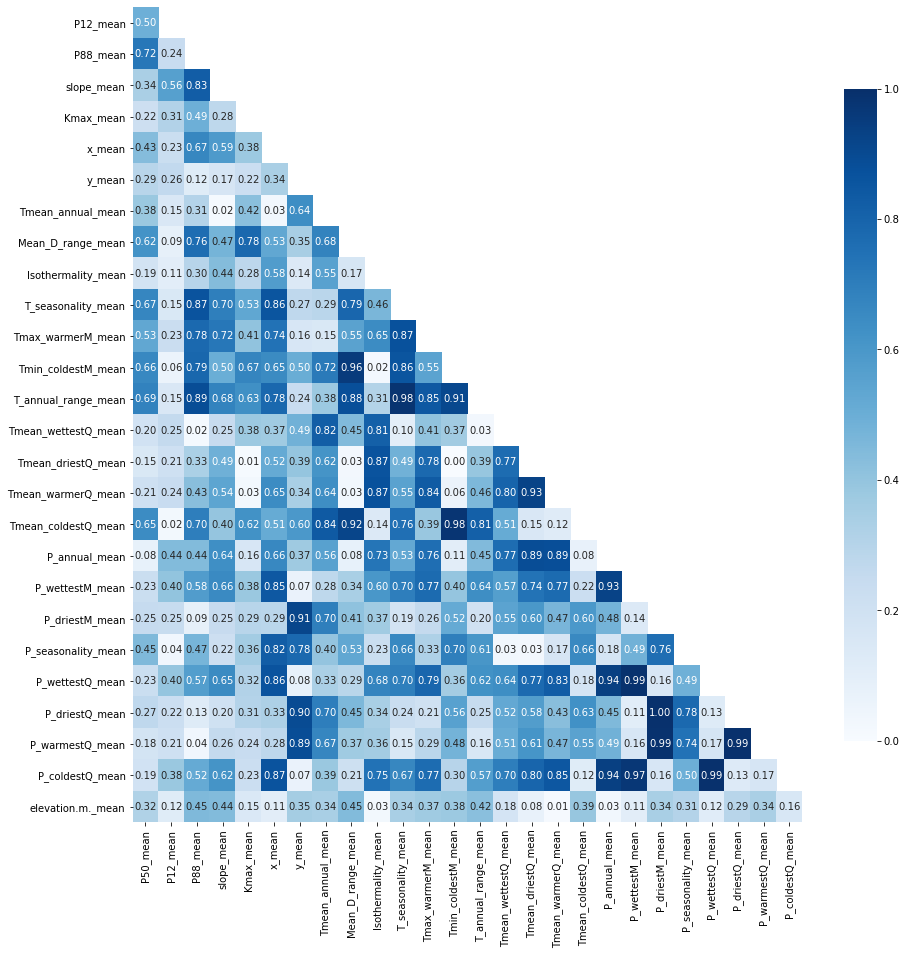

In [23]:
# mean values per population
df_corr= df_mean_pp[label_num].corr()
plot_heatmap(cor=df_corr, mode='abs', ann=True)

Strongest correlation between P50 and:
- Mean d range
- T season
- Tmin coldest
- T annual range
- T coldest Q


### Pairwise comparisons

#### Individual level

In [24]:
import plotly.express as px

fig = px.scatter(df_pp, x="Tmean_annual", y="P50", color="Treatment", trendline="ols", title = 'P50 vs Tmean')
fig.show()

results = px.get_trendline_results(fig)
print(results)

# results.query("Treatment == 'adult'").px_fit_results.iloc[0].summary()
# results.query("Treatment == 'young'").px_fit_results.iloc[0].summary()

  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


Very weak R² between individuals measure of P50 and T mean annual of the pop (R² = 0.02 and 0.06)

#### Population level

*Without the Treatment effect*

In [25]:
df_mean_pp_wide = df_mean_pp[["Tmean_annual_mean",
                                  'Tmean_coldestQ_mean',
                                  'T_seasonality_mean',
                                  'T_annual_range_mean',
                                  'Tmin_coldestM_mean',
                                  "P50_mean",
                                  
                                  'site']]


df_mean_pp_wide = pd.melt(df_mean_pp_wide, 
                            id_vars=[
                                     'site', 
                                     "P50_mean"], 
                            value_vars=["Tmean_annual_mean",
                                        'Tmean_coldestQ_mean',
                                        'T_seasonality_mean',
                                        'T_annual_range_mean',
                                        'Tmin_coldestM_mean'
                                        ])

df_mean_pp_wide.columns

Index(['site', 'P50_mean', 'variable', 'value'], dtype='object')

In [26]:
fig = px.scatter(df_mean_pp_wide, 
                 x="value", 
                 y="P50_mean", 
                
                 trendline="ols", 
                 text = "site",
                 facet_col="variable", 
                 facet_col_wrap=3,
                 facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 height=800, width=1000)
fig.update_traces(textposition='top center')
fig.update_xaxes(matches=None)
fig.show()

**NB : Oin (es, fr & P) is a common garden located in corogna (spain) with 3 provenances (spanish, portugese (Leiria) and Frecnh)**

*With the Treament effect*

In [27]:
df_mean_pp_T_wide = df_mean_pp_T[["Tmean_annual_mean",
                                  'Tmean_coldestQ_mean',
                                  'T_seasonality_mean',
                                  'T_annual_range_mean',
                                  'Tmin_coldestM_mean',
                                  "P50_mean",
                                  "Treatment",
                                  'site']]


df_mean_pp_T_wide = pd.melt(df_mean_pp_T_wide, 
                            id_vars=["Treatment", 
                                     'site', 
                                     "P50_mean"], 
                            value_vars=["Tmean_annual_mean",
                                        'Tmean_coldestQ_mean',
                                        'T_seasonality_mean',
                                        'T_annual_range_mean',
                                        'Tmin_coldestM_mean'
                                        ])

df_mean_pp_T_wide.columns

Index(['Treatment', 'site', 'P50_mean', 'variable', 'value'], dtype='object')

In [28]:
fig = px.scatter(df_mean_pp_T_wide, 
                 x="value", 
                 y="P50_mean", 
                 color="Treatment", 
                 trendline="ols", 
                 text = "site",
                 facet_col="variable", 
                 facet_col_wrap=3,
                 facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 height=800, width=1000)
fig.update_traces(textposition='top center')
fig.update_xaxes(matches=None)
fig.show()

In [29]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Tmean_coldestQ_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


Results:

Some traits some to be more correlated to p50 as seen on the heatmap, with maybe some slight differences between treatment

## PCA on bioclim var

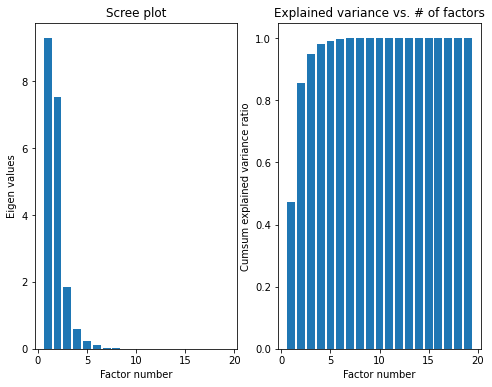

In [30]:
mypca = MyPCA(df_mean_pp_T[[v +'_mean' for v in values]] )
mypca.standardize()
mypca.dopca()
mypca.assess_pca()

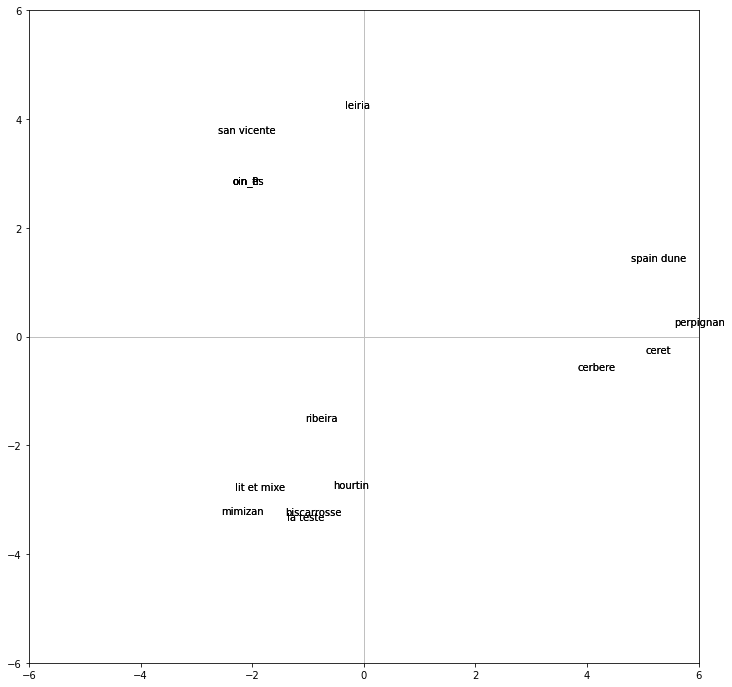

In [31]:
mypca.plot_indiv(label = df_mean_pp_T.site)

computing factor variable correlation


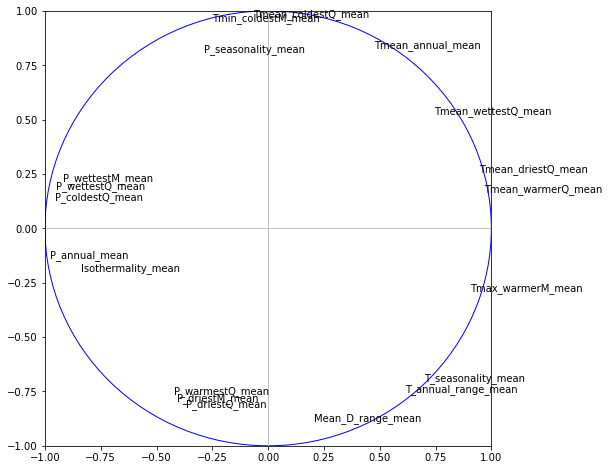

In [32]:
mypca.plot_features(label = df_mean_pp_T[[v +'_mean' for v in values]].columns)

In [33]:
mypca.compute_cos2()

Axis 1
---------------------------------------------

                     id    COS2_1    COS2_2
11        P_annual_mean  0.951331  0.017907
9    Tmean_warmerQ_mean  0.934700  0.027891
18      P_coldestQ_mean  0.913959  0.017581
15      P_wettestQ_mean  0.904088  0.032900
8    Tmean_driestQ_mean  0.890834  0.068485
12      P_wettestM_mean  0.848844  0.048381
4     Tmax_warmerM_mean  0.816849  0.083702
2    Isothermality_mean  0.705852  0.037595
7   Tmean_wettestQ_mean  0.555087  0.275527
3    T_seasonality_mean  0.487385  0.493582
6   T_annual_range_mean  0.374885  0.562389
0     Tmean_annual_mean  0.226235  0.688828
17      P_warmestQ_mean  0.177861  0.577456
13       P_driestM_mean  0.166879  0.629171
16       P_driestQ_mean  0.136495  0.674088
14   P_seasonality_mean  0.082023  0.659366
5    Tmin_coldestM_mean  0.063885  0.909944
1     Mean_D_range_mean  0.042149  0.785953
10  Tmean_coldestQ_mean  0.004734  0.945230
Axis 2
---------------------------------------------

            

### Plot P50 again PCA axis

In [34]:
acp_coord = pd.DataFrame(mypca.coord, columns = ['acp_'+str(i) for i in np.arange(0,mypca.coord.shape[1])])
df_mean_pp_T_acp = pd.concat([df_mean_pp_T, acp_coord], axis = 1)

In [35]:
fig = px.scatter(df_mean_pp_T_acp, x="acp_0", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [36]:
fig = px.scatter(df_mean_pp_T_acp, x="acp_1", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()

It seems that the correlation is better between p50 and the second axis of the PCA (R² = 0.23, 0.26) but it is not super wonderful, maybe fit a non linear model

first axis is associated with :
- (+) Tmean warmer Quarter
- (+) Tmean driest Quarter
- (-) P annual mean
- (-) P coldest Quarter

second axis is associated with :
- (+) Tmin coldest Quarter
- (+) Tmin coldest Month



## ACP on complete data set

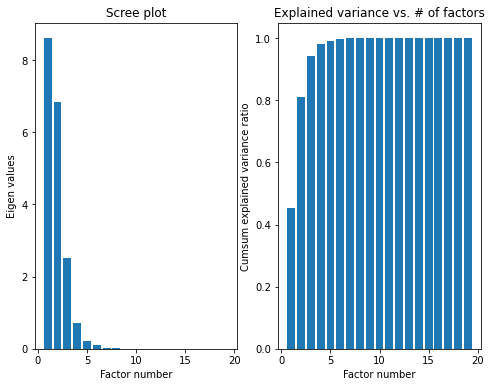

In [37]:
mypca = MyPCA(df_pp.iloc[:,bio_index] )
mypca.standardize()
mypca.dopca()
mypca.assess_pca()

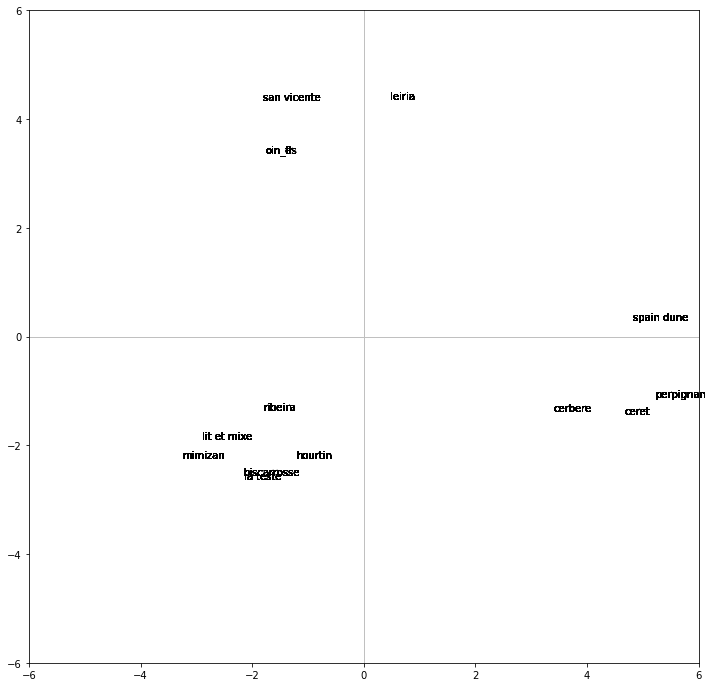

In [38]:
mypca.plot_indiv(label = df_pp.site)

In [39]:
acp_coord = pd.DataFrame(mypca.coord, columns = ['acp_'+str(i) for i in np.arange(0,mypca.coord.shape[1])])
df_pp_acp = pd.concat([df_pp, acp_coord], axis = 1)

In [40]:
df_pp_acp

Species         site Treatment       P50       P12       P88  \
0    pinus pinaster  biscarrosse     adult -3.818704 -3.358275 -4.279133   
1    pinus pinaster  biscarrosse     adult -3.855426 -3.378376 -4.332476   
2    pinus pinaster  biscarrosse     adult -3.198479 -1.852982 -4.543976   
3    pinus pinaster  biscarrosse     adult -3.969812 -3.138009 -4.801616   
4    pinus pinaster  biscarrosse     adult -3.690672 -2.621588 -4.759757   
..              ...          ...       ...       ...       ...       ...   
401  pinus pinaster   spain dune     young -4.043818 -3.638036 -4.449600   
402  pinus pinaster   spain dune     young -4.146582 -3.800240 -4.492924   
403  pinus pinaster   spain dune     young -4.289439 -3.779109 -4.799768   
404  pinus pinaster   spain dune     young -4.034442 -3.542476 -4.526408   
405  pinus pinaster   spain dune     young -4.870334 -4.441187 -5.299482   

          slope      Kmax  P50e  P12e  ...     acp_9    acp_10    acp_11  \
0    108.594361  0.000249   NaN   NaN  ...  0.011374 -0.010521  0.021952   
1    104.810817  0.001174   NaN   NaN  ...  0.011374 -0.010521  0.021952   
2     37.160995  0.000166   NaN   NaN  ...  0.011374 -0.010521  0.021952   
3     60.110348  0.000649   NaN   NaN  ...  0.011374 -0.010521  0.021952   
4     46.769004  0.000316   NaN   NaN  ...  0.011374 -0.010521  0.021952   
..          ...       ...   ...   ...  ...       ...       ...       ...   
401  123.218923  0.000442   NaN   NaN  ... -0.045354  0.001912 -0.003866   
402  144.366039  0.000563   NaN   NaN  ... -0.045354  0.001912 -0.003866   
403   97.975924  0.000518   NaN   NaN  ... -0.045354  0.001912 -0.003866   
404  101.633023  0.000279   NaN   NaN  ... -0.045354  0.001912 -0.003866   
405  116.510005  0.000130   NaN   NaN  ... -0.045354  0.001912 -0.003866   

           acp_12        acp_13        acp_14        acp_15        acp_16  \
0    1.742553e-14 -2.562713e-15  6.562988e-16  1.757072e-15  1.018737e-15   
1   -1.301024e-14 -5.843039e-15  4.330114e-15  7.712739e-15 -1.111454e-15   
2    1.203615e-14  1.084849e-14  5.895465e-15  1.719005e-15 -8.127979e-16   
3   -5.458366e-15 -5.211496e-15  7.063282e-15 -4.150001e-15  4.476353e-15   
4   -1.575041e-15  2.020730e-15 -6.474072e-15  4.717479e-15  2.699348e-15   
..            ...           ...           ...           ...           ...   
401 -4.419589e-17  9.924538e-17 -7.237682e-17 -3.776731e-17 -4.319509e-17   
402 -4.419589e-17  9.924538e-17 -7.237682e-17 -3.776731e-17 -4.319509e-17   
403 -8.050973e-17 -7.077755e-18 -1.774017e-16 -1.404371e-16  1.426712e-16   
404 -8.050973e-17 -7.077755e-18 -1.774017e-16 -1.404371e-16  1.426712e-16   
405 -5.379196e-17  1.105692e-16 -1.038585e-16 -7.192212e-17 -6.649003e-17   

           acp_17        acp_18  
0    1.548005e-15  6.524429e-16  
1    9.628795e-16 -3.028281e-16  
2    1.126734e-16 -1.060635e-16  
3   -1.331834e-16  4.451253e-16  
4   -1.617344e-16  1.131321e-15  
..            ...           ...  
401  2.538897e-16  7.589495e-17  
402  2.538897e-16  7.589495e-17  
403  8.191738e-17 -6.167276e-17  
404  8.191738e-17 -6.167276e-17  
405  2.868135e-16  4.927592e-17  

[406 rows x 63 columns]

### Saving data frame

In [41]:
if False:
    df_mean_pp_T_acp.to_csv("/home/xavier/Documents/research/FORMANRISK/analyse/forman_cavit/output/table/df_mean_PP.csv")
    df_pp_acp.to_csv("/home/xavier/Documents/research/FORMANRISK/analyse/forman_cavit/output/table/df_PP.csv")

## Stats models

In [42]:
# Import the linear regression model class
from pymer4.models import Lm

# Initialize model using 2 predictors and sample data
model = Lm("P50 ~ Treatment + site", data=df_pp_acp)

# Fit it
print(model.fit())

Formula: P50~Treatment+site

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 406	 R^2: 0.234	 R^2_adj: 0.205

Log-likelihood: -63.617 	 AIC: 159.235	 BIC: 223.336

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE   DF  T-stat  P-val  Sig
Intercept              -3.824  -3.943   -3.704  0.061  390 -63.042  0.000  ***
Treatment[T.young]      0.036  -0.021    0.093  0.029  390   1.249  0.212     
site[T.cerbere]         0.105  -0.056    0.265  0.082  390   1.279  0.202     
site[T.ceret]           0.155  -0.004    0.314  0.081  390   1.916  0.056    .
site[T.hourtin]        -0.070  -0.224    0.084  0.078  390  -0.892  0.373     
site[T.la teste]        0.096  -0.063    0.255  0.081  390   1.186  0.236     
site[T.leiria]         -0.237  -0.379   -0.094  0.073  390  -3.266  0.001   **
site[T.lit et mixe]     0.044  -0.111    0.199  0.079  390   0.556  0.579     
site[T.mimizan]         0.047  -0.

In [43]:
df_restricted = df_pp_acp[['P50','site', 'Treatment', 'acp_0', 'acp_1']]

### Full model

In [44]:
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts 
# this is the full model
model = Lmer("P50 ~ Treatment + acp_0 + acp_1 + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+acp_0+acp_1+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 15.0}

Log-likelihood: -93.971 	 AIC: 187.942

Random effects:

                 Name    Var    Std
site      (Intercept)  0.013  0.113
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.832  -3.902   -3.763  0.036   16.708 -107.951  0.000  ***
Treatmentyoung     0.035  -0.022    0.091  0.029  391.688    1.199  0.231     
acp_0              0.004  -0.018    0.026  0.011   11.899    0.361  0.725     
acp_1             -0.036  -0.060   -0.012  0.012   12.381   -2.898  0.013    *


### Simplest model with only Treatment & site as random

In [45]:
# Initialize model instance using 1 predictor with random intercepts 
# no climatic variables
model = Lmer("P50 ~ Treatment + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 15.0}

Log-likelihood: -90.611 	 AIC: 181.221

Random effects:

                 Name    Var    Std
site      (Intercept)  0.021  0.143
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)       -3.838  -3.921   -3.755  0.042   18.050 -91.061  0.000  ***
Treatmentyoung     0.038  -0.019    0.094  0.029  392.474   1.307  0.192     


### Selected model (with & without interaction)

In [46]:
# Initialize model instance using 1 predictor with random intercepts 
model = Lmer("P50 ~ Treatment + acp_1 + (acp_1|site)", data=df_restricted)

# Fit it
print(model.fit())

boundary (singular) fit: see ?isSingular 

Formula: P50~Treatment+acp_1+(acp_1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 15.0}

Log-likelihood: -90.431 	 AIC: 180.862

Random effects:

                 Name    Var    Std
site      (Intercept)  0.012  0.108
site            acp_1  0.000  0.002
Residual               0.083  0.289

              IV1    IV2  Corr
site  (Intercept)  acp_1   1.0

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.833  -3.900   -3.765  0.034   18.530 -111.193  0.000  ***
Treatmentyoung     0.035  -0.022    0.091  0.029  391.801    1.197  0.232     
acp_1             -0.036  -0.060   -0.012  0.012    5.583   -2.941  0.028    *


In [47]:
# Initialize model instance using 1 predictor with random intercepts and slopes
model = Lmer("P50 ~  Treatment + acp_1 + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+acp_1+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 15.0}

Log-likelihood: -90.438 	 AIC: 180.877

Random effects:

                 Name    Var    Std
site      (Intercept)  0.012  0.108
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.833  -3.900   -3.765  0.034   18.521 -111.211  0.000  ***
Treatmentyoung     0.035  -0.022    0.091  0.029  391.798    1.195  0.233     
acp_1             -0.036  -0.060   -0.013  0.012   13.501   -3.038  0.009   **


This is the best model based on AIC value (both models random intercep & random intercept + slope perform very similarly)

No effect of treatment
effect on acp_1 which is the second axis of the pca correlated with :

- (+) Tmin coldest Quarter
- (+) Tmin coldest Month

In [48]:
# Visualize coefficients with group/cluster fits overlaid ("forest plot")
model.plot_summary()

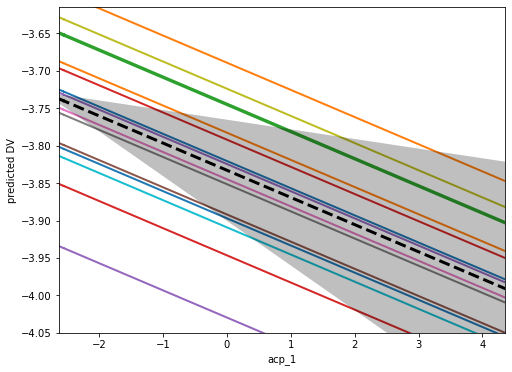

In [49]:
model.plot("acp_1", plot_ci=True, ylabel="predicted DV")

## Test with R

In [50]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri

base = importr('base') 
stats = importr('stats')
graphics = importr('graphics')
utils = importr('utils')
ade4 = importr('ade4')
nlme = importr('nlme')
lme4 = importr('lme4')
lmertest = importr('lmerTest')


from rpy2.robjects.conversion import localconverter

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [51]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_restricted_r = ro.conversion.py2rpy(df_restricted)

base.dim(df_restricted_r)

<rpy2.robjects.vectors.IntVector object at 0x7f562065f040> [RTYPES.INTSXP]
R classes: ('integer',)
[406, 5]

In [52]:
from rpy2.robjects.packages import importr
utils = importr('utils')

In [53]:
%load_ext rpy2.ipython

In [54]:
%%R -i df_restricted_r

require(tidyverse)
require(dplyr)
require(lme4)
require(nlme)
require(lmerTest)
# glimpse(df_restricted_r)

In [55]:
%%R

df_restricted_r[,'Treatment'] = as.factor(df_restricted_r[,'Treatment'] )
df_restricted_r[,'site'] = as.factor(df_restricted_r[,'site'] )
mm1 = lmer(P50 ~ Treatment + acp_1 + (1|site), data = df_restricted_r)
summary(mm1)



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: P50 ~ Treatment + acp_1 + (1 | site)
   Data: df_restricted_r

REML criterion at convergence: 180.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2796 -0.4813 -0.0200  0.6213  2.8447 

Random effects:
 Groups   Name        Variance Std.Dev.
 site     (Intercept) 0.01164  0.1079  
 Residual             0.08337  0.2887  
Number of obs: 406, groups:  site, 15

Fixed effects:
                Estimate Std. Error        df  t value Pr(>|t|)    
(Intercept)     -3.83274    0.03446  18.52107 -111.211  < 2e-16 ***
Treatmentyoung   0.03455    0.02890 391.79791    1.195  0.23273    
acp_1           -0.03631    0.01195  13.50086   -3.038  0.00918 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Trtmnt
Treatmntyng -0.401       
acp_1       -0.052  0.047


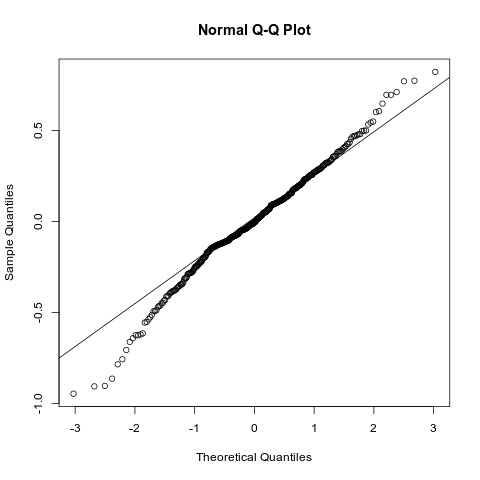

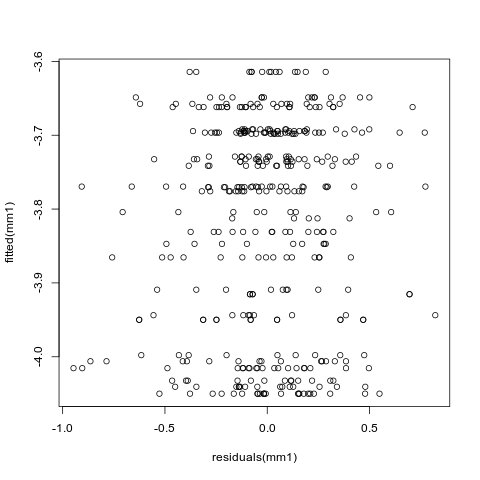

In [56]:
%%R
hist(residuals(mm1))
qqnorm(residuals(mm1))
qqline(residuals(mm1))

plot(fitted(mm1)~residuals(mm1))


In [57]:
%%R
plot(residuals(mm1)~as.factor(df_restricted_r[,'Treatment']))

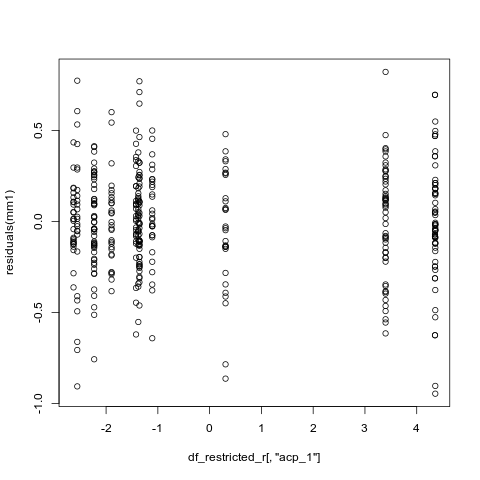

In [58]:
%%R
plot(residuals(mm1)~df_restricted_r[,'acp_0'])
plot(residuals(mm1)~df_restricted_r[,'acp_1'])

## STILL IN DEVELOPMENT

## Bayesian modelling

In [192]:
import pyjags
import numpy as np

np.random.seed(0)
np.set_printoptions(precision=3)

In [203]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [224]:
treat_le = le.fit_transform(df_restricted.Treatment)+1
site_le = le.fit_transform(df_restricted.site)+1

In [276]:
code = '''
model {
    for (i in 1:N) {        
        y[i] ~ dnorm(a0 + a1[Treatment[i]] + a2*Covar[i] + A3[Site[i]] , tau)
    }
    
    a0~dnorm(-3.8, 1e-4)    
    tau  ~ dgamma(1e-4, 1e-4)      
    
    a2~dnorm(0, 1e-4)
    
    for(t in 1:2){
        a1[t]~dnorm(0.0, 1e-4)
    }
    
    for(s in 1:NSITE){
        A3[s]~dnorm(0.0, tauS)
    }
    tauS ~ dgamma(1e-4, 1e-4)  

}
'''

model = pyjags.Model(code, data=dict(Treatment=treat_le, 
                                     Covar=df_restricted.acp_1,
                                     Site=site_le,
                                     y = df_restricted.P50,
                                     N=df_restricted.shape[0],
                                     NSITE=df_restricted.site.unique().shape[0]), 
                     chains=4, 
                     threads=4,
                     chains_per_thread=1)

var = ['a0', 'a1', 'a2', 'A3', 'tauS']

# warmup / burn-in iterations, not used for inference.
model.sample(10000, vars=[])
samples = model.sample(10000, 
                       vars=var,
                       thin = 10)

def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} median = {:>5.3f}, {}% credible interval [{:>4.3f} {:>4.3f}]'.format(
      varname, np.median(values), p, *ci))

for varname in var:
    summary(samples, varname)

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00
a0     median = -3.141, 95% credible interval [-8.646 -0.690]
a1     median = -0.680, 95% credible interval [-128.705 128.360]
a2     median = -0.037, 95% credible interval [-0.058 -0.016]
A3     median = 0.004, 95% credible interval [-0.189 0.168]
tauS   median = 86.693, 95% credible interval [35.821 238.585]


Formula: P50~Treatment+acp_1+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 15.0}

Log-likelihood: -90.438 	 AIC: 180.877

Random effects:

                 Name    Var    Std
site      (Intercept)  0.012  0.108
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.833  -3.900   -3.765  0.034   18.521 -111.211  0.000  ***
Treatmentyoung     0.035  -0.022    0.091  0.029  391.798    1.195  0.233     
acp_1             -0.036  -0.060   -0.013  0.012   13.501   -3.038  0.009   **


In [275]:
plt.hist(np.ravel(samples['a0']))

(array([231., 934., 795., 844., 208., 112., 104., 239., 206., 327.]),
 array([-12.286, -11.322, -10.359,  -9.395,  -8.432,  -7.468,  -6.504,
         -5.541,  -4.577,  -3.614,  -2.65 ]),
 <a list of 10 Patch objects>)